## Importing relevant modules

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import transformers
from transformers import BertModel, BertTokenizer

We will be using the BertModel and BertTokenizer to obtain the word embeddings. There are other ways to do this but this is a bit easier in my opinion.

## Reading the dataset
The dataset in [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) is in the form of json files. So, first we convert that to csv. The commented out code block does this.

In [ ]:
# try:
#     df = pd.read_json('Sarcasm_Headlines_Dataset.json', encoding='utf-8')
#     df.to_csv('sarcasm_headlines.csv', encoding='utf-8', index=False)
# except ValueError as e:
#     print(f"ValueError: {e}")

# # Option 2: Read JSON file line by line and then convert
# try:
#     with open('Sarcasm_Headlines_Dataset.json', 'r', encoding='utf-8') as inputfile:
#         data = [json.loads(line) for line in inputfile]
#     df = pd.DataFrame(data)
#     df.to_csv('sarcasm_headlines.csv', encoding='utf-8', index=False)
# except ValueError as e:
#     print(f"ValueError: {e}")

In [ ]:
df = pd.read_csv("sarcasm_headlines.csv")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Now, we will check to which sites, the articles belong

## Data pre-processing

In this section, we will try to observe patterns in the data and extract good features (if any).

In [ ]:
domain_name = []

for i in df['article_link']:
    domain_name.append(i.split('/')[2])

df.insert(2, 'domain_name', domain_name)
df.head(5)

,article_link,headline,domain_name,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,www.huffingtonpost.com,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,www.huffingtonpost.com,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,local.theonion.com,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",politics.theonion.com,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,www.huffingtonpost.com,0


In [ ]:
df['domain_name'] = df['domain_name'].replace({'www.huffingtonpost.comhttp:': 'www.huffingtonpost.com', 'www.huffingtonpost.comhttps:': 'www.huffingtonpost.com'})
df['domain_name'].unique()

array(['www.huffingtonpost.com', 'local.theonion.com',
       'politics.theonion.com', 'entertainment.theonion.com',
       'www.theonion.com', 'sports.theonion.com'], dtype=object)

Even though there are 6 unique domain names, all the articles can be classified either as a huffingtonpost article or the onion article

In [ ]:
df['domain_name'] = df['domain_name'].replace({
    'local.theonion.com': 'theonion',
    'politics.theonion.com': 'theonion',
    'entertainment.theonion.com': 'theonion',
    'sports.theonion.com': 'theonion',
    'www.theonion.com': 'theonion',
    'www.huffingtonpost.com': 'huffingtonpost'
})

df['domain_name'].unique()

array(['huffingtonpost', 'theonion'], dtype=object)

We will drop the article link since we got the domain name. The headline will give us more than enough information.

In [ ]:
df.drop('article_link', axis = 1, inplace = True)

We will observe the correlation between the domain name and the article's measure of sarcasm.

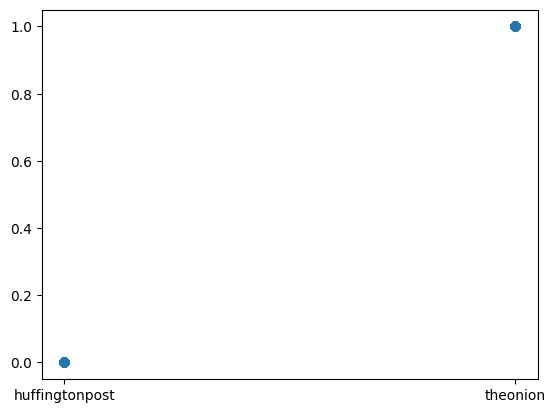

In [ ]:
plt.scatter(df['domain_name'], df['is_sarcastic'])
plt.show()

We can observe that all the huffingtonpost articles are non-sarcastic and all theonion articles are sarcastic (this is also mentioned in the dataset. So, technically we can achieve 100% accuracy without even using an LSTM. But where is the fun in that?

Moreover what we are trying to do is to build a model that is able to sense sarcasm irrespective of the content being theonion article or the huffingtonpost article.

Let us check for any duplicate entries and remove them.

In [ ]:
len(df['headline'].unique()) == len(df['headline'])

False

In [ ]:
df[df.duplicated(subset=['headline'], keep=False)]

,headline,domain_name,is_sarcastic
182,magic-markered initials fail to deter breakroo...,theonion,1
533,antarctic observational comic running out of i...,theonion,1
1019,the best chance to defeat roy moore may be for...,huffingtonpost,0
1091,antarctic observational comic running out of i...,theonion,1
1131,pier 1 issues formal apology for rattan death ...,theonion,1
...,...,...,...
26121,"'no way to prevent this,' says only nation whe...",theonion,1
26156,"area man busts his ass all day, and for what?",theonion,1
26353,kleenex box inadequately covered,theonion,1
26500,candy purchase puts yet more money in raisinet...,theonion,1


In [ ]:
df = df.drop_duplicates(subset=['headline'])

## Building the Dataset and the Model

First, we declare the device.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Then, we intialize the Bert Model and Tokenizer that we will use to extract the word embeddings.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased").to(device)

These are some standard variable and hyperparameters which will come into use as we will see.

In [ ]:
MAX_LEN = 128
LEARNING_RATE = 3e-05
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 6

Then, we construct our CustomDataset class which would handle our embedding generation and the batching of training examples.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, max_len, tokenizer, model, device):
        self.data = df
        self.text = self.data.headline
        self.targets = self.data.is_sarcastic
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.model = model
        self.device = device

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = str(self.text[idx])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze(0).to(self.device)  # Move to device
        attention_mask = inputs['attention_mask'].squeeze(0).to(self.device)  # Move to device

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))

        embedding = outputs.last_hidden_state.squeeze(0).to(self.device)  # Move to device

        return {
            "embedding": embedding,
            "targets": torch.tensor(self.targets[idx], dtype=torch.float).to(self.device)  # Move to device
        }

We split the dataset into training and testing.

In [ ]:
train_size = 0.8
train_dataset = df.sample(frac=train_size, random_state=42)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
training_set = CustomDataset(train_dataset, MAX_LEN, tokenizer=tokenizer, model=model, device=device)
testing_set = CustomDataset(test_dataset, MAX_LEN, tokenizer=tokenizer, model=model,device=device)

In [ ]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle = True)
test_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=True)

Our model is going to consist of a stacked bi-directional LSTM. The parameters like dropout of the LSTM and its hidden size can be experimented on. These are the values I found worked the best. (In all honesty, there could be better values for the parameters, but I don't think that will affect the model significantly.)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(CustomModel, self).__init__()
        self.layer1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, dropout=0.2, bidirectional=True)
        #self.dropout = nn.Dropout(0.3)   #From my observations, I don't think the dropout layer improves the model's performance
        self.layer2 = nn.Linear(hidden_size*2, 1)
        self.layer3 = nn.Sigmoid()

    def forward(self, x):
        output, (h_n, c_n) = self.layer1(x)
        output = output[:, -1, :]
        #output = self.dropout(output)
        return self.layer3(self.layer2(output))

In [ ]:
SeqModel = CustomModel(256, 768)
SeqModel.to(device)

CustomModel(
  (layer1): LSTM(768, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (layer2): Linear(in_features=512, out_features=1, bias=True)
  (layer3): Sigmoid()
)

## The Training and Testing Process

Just a little sidenote. Since, I am still a beginner, one (silly) mistake that I made was to use BCEWithLogitsLoss() instead of BCELoss() as the loss function. As the model didn't learn very well, I realised my mistake and used the correct function. This [StackOverflow](https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss) post explains the difference.

In [ ]:
optimizer = torch.optim.AdamW(params=SeqModel.parameters(), lr=LEARNING_RATE)
lossfn = nn.BCELoss()

In [ ]:
losses = []

def training(train_loader, modl, epoch):
    modl.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        embed = batch['embedding'].to(device)
        target = batch['targets'].to(device)

        preds = modl(embed)
        preds = preds.squeeze(-1)
        loss = lossfn(preds, target)

        total_loss += loss.item()
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
          print(f"Epoch: {epoch}, loss: {loss:.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")

In [ ]:
for epoch in range(EPOCHS):
  training(training_loader, SeqModel, epoch)

Epoch: 0, loss: 0.6948
Epoch: 0, loss: 0.6863
Epoch: 0, loss: 0.6465
Epoch: 0, loss: 0.6090
Epoch: 0, loss: 0.5239
Epoch: 0, loss: 0.4372
Epoch: 0, loss: 0.4181
Average training loss: 0.5798
Epoch: 1, loss: 0.4909
Epoch: 1, loss: 0.3974
Epoch: 1, loss: 0.5947
Epoch: 1, loss: 0.3608
Epoch: 1, loss: 0.5129
Epoch: 1, loss: 0.5600
Epoch: 1, loss: 0.4031
Average training loss: 0.4205
Epoch: 2, loss: 0.3721
Epoch: 2, loss: 0.3910
Epoch: 2, loss: 0.3470
Epoch: 2, loss: 0.3464
Epoch: 2, loss: 0.3145
Epoch: 2, loss: 0.3929
Epoch: 2, loss: 0.3986
Average training loss: 0.3875
Epoch: 3, loss: 0.5895
Epoch: 3, loss: 0.3706
Epoch: 3, loss: 0.3916
Epoch: 3, loss: 0.4057
Epoch: 3, loss: 0.4538
Epoch: 3, loss: 0.3276
Epoch: 3, loss: 0.5742
Average training loss: 0.3710
Epoch: 4, loss: 0.3701
Epoch: 4, loss: 0.3389
Epoch: 4, loss: 0.2854
Epoch: 4, loss: 0.3270
Epoch: 4, loss: 0.4494
Epoch: 4, loss: 0.3013
Epoch: 4, loss: 0.2489
Average training loss: 0.3581
Epoch: 5, loss: 0.4241
Epoch: 5, loss: 0.4375

Let us plot the training curve. NOTE: The training curve when plotted all the losses just looked like a mess hence I am taking in the interval of 500 examples

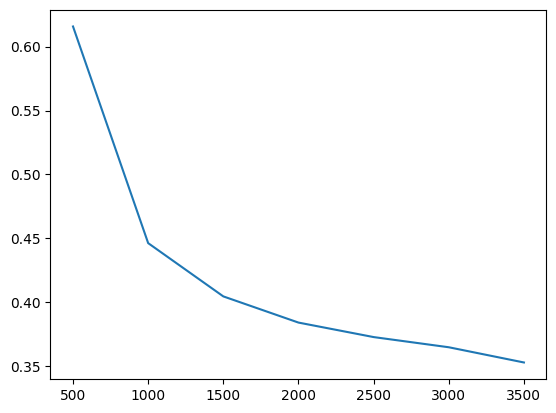

In [ ]:
lst = [(i, sum(losses[i-500:i])/500) for i in range(1, len(losses)) if i % 500 == 0]
plt.plot([i for (i, j) in lst], [j for (i, j) in lst])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def testing(test_loader, modl):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['targets'].to(device)

            outputs = modl(embeddings)
            outputs = outputs.squeeze(-1)

            preds = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

In [ ]:
all_labels, all_preds = testing(test_loader, SeqModel)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8517
Precision: 0.8330
Recall: 0.8188
F1 Score: 0.8259


These are pretty good metrics overall.

## LSTM: Long-Short Term Memory

To understand LSTMs, you must know about RNNs, after all LSTM is a type of RNN. A problem with vanilla-RNN is the vanishing gradients problem. This resulted in the RNN not able perform well on tasks that would require to take into consideration certain parameters on the long-term.

To be able to selectively, keep a certain piece of information in the "long" term and in the "short" term is the key feature of an LSTM. The LSTM cell acieves this using three types of gate:- forget, input, and output. Each LSTM cell has a hidden state along with the cell memory.

### Forget Gate

The forget gate aids in deciding "how much" of a piece of information from the past should be remembered. So, from this definition, we get the idea of product (more specifically Hadamard product in this case), of a quantity with another quantity from the previous time step. What is the former quantity? The former quantity in question is $f_{(t)}$ (the latter quantity being, the past cell memory, $c_{(t-1)}$) and its dependence is discussed below. P.S. the product contributes to the cell memory, $c_{(t)}$.

We can see that the quantity given out by the forget gate, $f_{(t)}$, depends on the input, $x_{(t)}$ and the hidden state of the cell in the previous iteration, $h_{(t-1)}$. The relation is given as follows:-
$$ f_{(t)} = \sigma(U^{(f)}h_{(t-1)} + W^{(f)}x_{(t)})$$

There are two weight matrices associated with forget gate, one for the previous hidden state and the other for the input. The significance of the sigmoid function is its range of 0 to 1. This feature is used to generate the probabilities* that the certain feature of the cell would be useful in learning the pattern or generating the output. In this case, $f_{(t)}$ acts as an indicator/selector with regards to how much the history of the cell memory, $c_{(t-1)}$ influences its current predictions and learning.

NOTE: All the values generated by all the gates would be used on the operation of Hadamard product to generate new state values of the cell. This is evident as all the outputs of the gate are the output of the sigmoid function (and can be thought of as probabilities).

*They are not technically probabilities. These quantities generated by the gate can be thought of as influencing "how much" of a certain state value should "flow", i.e., to what extent will, say, $c_{(t-1)}$ influence, say, the cell memory, $c_{(t)}$

### Input gate

The input gate functions as a valve, deciding to what extent (from 0% to 100%) the candidate cell memory, $\tilde{c}_{(t)}$ would contribute to the cell memory, $c_{(t)}$. Similar, to the forget gate, the quantity given out by this gate depends on the input and the previous hidden state of the cell. The relation is as follows:-

$$i_{(t)} = \sigma(U^{(i)}h_{(t-1)} + W^{(i)}x_{(t)})$$

NOTE:-  The weight matrices associated with different gates are not the same.

Let us look at the candidate cell memory. The candidate cell memory is as the name states, a candidate for the cell memory at this time step. It is determined purely by the input and the previous hidden state. It is given as follows:-


  $$ \tilde{c}_{(t)} = tanh(U^{(c)}h_{(t-1)} +  W^{(c)}x_{(t)})$$

We don't completely use candidate cell memory because of that would defeat the purpose of LSTM - the ability to store information selectively in the long term as well as short term, and therefore would not solve the main issue of vanilla RNNs. Another thing you might be wondering is why the tanh function? This [StackOverflow](https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm) post explains why.

## Output gate

The output gate produces $o_{(t)}$ which controls the contribution of $c_{(t)}$ for $h_{(t)}$. It acts very similar to the outputs of the previous gates. Now, let us see how $c_{(t)}$ and $o_{(t)}$ is defined.

$$c_{(t)} = f_{(t)} * c_{(t - 1)} + i_{(t)} * \tilde{c}_{(t - 1)}$$

$$o_{(t)} = \sigma(U^{(o)}h_{(t-1)} + W^{(o)}x_{(t)})$$

The final output of the LSTM which is (by default) the last hidden state, $h_{t}$. It is given by:-

$$h_{(t)} = o_{(t)} * tanh(c_{(t)})$$

The reason for the tanh function can be thought of as its range of [-1, 1] which doesn't lead to exploding values. Another reason is due to better learning of models in practice as compared to sigmoid.